In [11]:
"""Cell 1: Load the grid dataset into a dataloader"""
import numpy as np
import torch
from nfv.flows import Greenshield
from nfv.problem import Problem
from nfv.solvers import LaxHopf
from operator_data_pipeline import GridDataset, PiecewiseRandom, preprocess_grids
from torch.utils.data import DataLoader

# Grid parameters
nx = 50
nt = 250
dx = 0.25
dt = 0.05
batch_size = 4
n_samples = 10

# Generate piecewise constant initial conditions
ics = [PiecewiseRandom(ks=[1.0, 0.3], x_noise=False) for _ in range(n_samples)]

# Solve using Lax-Hopf solver
problem = Problem(nx=nx, nt=nt, dx=dx, dt=dt, ic=ics, flow=Greenshield())
grids = problem.solve(LaxHopf, batch_size=batch_size, dtype=torch.float64, progressbar=True).cpu().numpy()

# Create dataset and dataloader
dataset = GridDataset(preprocess_grids(grids, nx, nt, dx, dt))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

print(f"Dataset size: {len(dataset)}")
print(f"Number of batches: {len(dataloader)}")

3it [00:00, 14.87it/s]                       

Dataset size: 10
Number of batches: 3


In [12]:
"""Cell 2: Load the latest model from operator.pth"""
from model import OperatorModel
from models.wave_front_pred import WaveFront

# Initialize the model with the same architecture
model = OperatorModel(
    WaveFront,
    n_modes=(16, 8),
    hidden_dim=32,
    in_channels=3,
    out_channels=1,
    n_layers=4,
)

# Load state dict and filter out neuralop metadata key
state_dict = torch.load('operator.pth', weights_only=False)
state_dict = {k: v for k, v in state_dict.items() if k != '_metadata'}
model.load_state_dict(state_dict)
model.eval()

print(f"Model loaded successfully from operator.pth")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

Model loaded successfully from operator.pth
Total parameters: 354,643


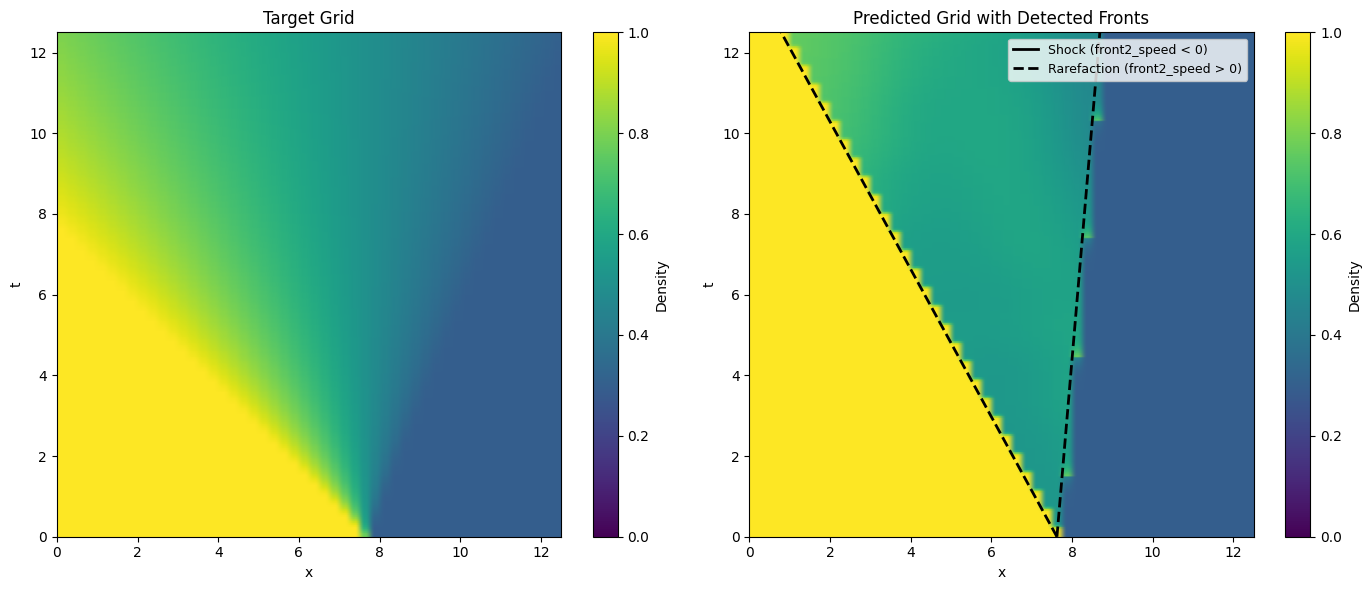


Front information for sample 0:
Number of valid fronts: 1
  Front 1: x0=7.625, front1_speed=-0.547, front2_speed=0.085 (Rarefaction)


In [13]:
"""Cell 3: Plot target vs predicted with front lines"""
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Get a batch of data
grid, target = next(iter(dataloader))

# Run model prediction
with torch.no_grad():
    pred = model(grid)
    # Get front parameters from the model
    ic = grid[:, :, 0, :]  # (B, C, X) - initial condition
    front_params, front_count = model.model.front_detector(ic)

# Select sample to plot
idx = 0

# Extract front info for the selected sample
# front_params shape: (B, 5, K) with channels [front1_speed, front2_speed, uL, uR, front_coords]
front1_speed = front_params[idx, 0, :].cpu().numpy()  # (K,)
front2_speed = front_params[idx, 1, :].cpu().numpy()  # (K,)
front_coords = front_params[idx, 4, :].cpu().numpy()  # (K,)

# Create time and space arrays for plotting
t_vals = np.linspace(0, nt * dt, nt)
x_vals = np.linspace(0, nx * dx, nx)

# Create figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6), facecolor='white')

# Plot target grid
ax1 = axes[0]
target_data = target[idx].squeeze().detach().cpu().numpy()
im1 = ax1.imshow(
    target_data,
    aspect='auto',
    origin='lower',
    extent=[0, nx * dx, 0, nt * dt],
    cmap='viridis',
    vmin=0,
    vmax=1
)
ax1.set_xlabel('x')
ax1.set_ylabel('t')
ax1.set_title('Target Grid')
plt.colorbar(im1, ax=ax1, label='Density')

# Plot predicted grid with fronts
ax2 = axes[1]
pred_data = pred[idx].squeeze().detach().cpu().numpy()
im2 = ax2.imshow(
    pred_data,
    aspect='auto',
    origin='lower',
    extent=[0, nx * dx, 0, nt * dt],
    cmap='viridis',
    vmin=0,
    vmax=1
)
ax2.set_xlabel('x')
ax2.set_ylabel('t')
ax2.set_title('Predicted Grid with Detected Fronts')
plt.colorbar(im2, ax=ax2, label='Density')

# Plot fronts on the predicted grid
# front2_speed < 0: shock (single front), front2_speed > 0: rarefaction (two fronts)
# front2_speed == 0: invalid front
for k in range(front_count[idx].item()):
    if front2_speed[k] != 0:  # Valid front
        x0 = front_coords[k]
        
        # Front 1 trajectory (always present for valid fronts)
        x1_trajectory = x0 + front1_speed[k] * t_vals
        
        if front2_speed[k] < 0:
            # Shock: single front (solid line)
            ax2.plot(x1_trajectory, t_vals, 'k-', linewidth=2.0)
        else:
            # Rarefaction: two fronts (dashed lines)
            ax2.plot(x1_trajectory, t_vals, 'k--', linewidth=2.0)
            # Front 2 trajectory
            x2_trajectory = x0 + front2_speed[k] * t_vals
            ax2.plot(x2_trajectory, t_vals, 'k--', linewidth=2.0)

# Set axis limits for predicted plot
ax2.set_xlim(0, nx * dx)
ax2.set_ylim(0, nt * dt)

# Add legend for front types
legend_elements = [
    Line2D([0], [0], color='black', linestyle='-', linewidth=2, label='Shock (front2_speed < 0)'),
    Line2D([0], [0], color='black', linestyle='--', linewidth=2, label='Rarefaction (front2_speed > 0)')
]
ax2.legend(handles=legend_elements, loc='upper right', fontsize=9)

plt.tight_layout()
plt.show()

# Print front information
print(f"\nFront information for sample {idx}:")
print(f"Number of valid fronts: {front_count[idx].item()}")
for k in range(front_count[idx].item()):
    if front2_speed[k] != 0:
        front_type = "Shock" if front2_speed[k] < 0 else "Rarefaction"
        print(f"  Front {k+1}: x0={front_coords[k]:.3f}, front1_speed={front1_speed[k]:.3f}, "
              f"front2_speed={front2_speed[k]:.3f} ({front_type})")

In [14]:
grid[0, 0, 0], pred[0, 0, 0]

(tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000,
         0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000,
         0.3000, 0.3000, 0.3000, 0.3000, 0.3000]),
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000,
         0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000,
         0.3000, 0.3000, 0.3000, 0.3000, 0.3000]))

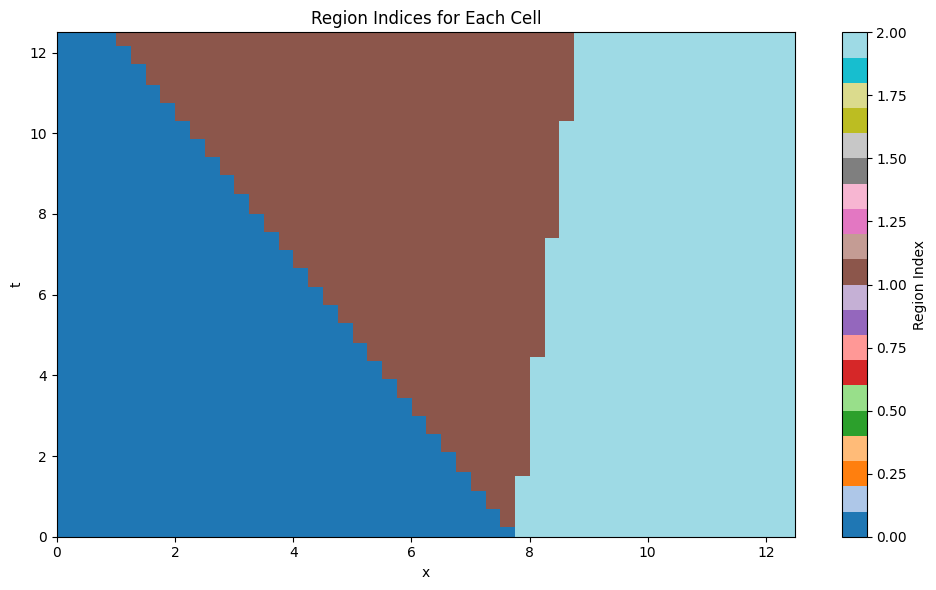


Region index statistics for sample 0:
  Shape: (250, 50)
  Min index: 0, Max index: 2
  Unique region indices: [0, 1, 2]


In [15]:
"""Cell 4: Plot region indices for each cell"""
import matplotlib.pyplot as plt
import numpy as np

# Run model prediction
with torch.no_grad():
    preds = model(grid)
    # Get front parameters from the model
    ic = grid[:, :, 0, :]  # (B, C, X) - initial condition
    front_params, front_count = model.model.front_detector(ic)

# Select sample to plot
idx = 0

# Get region indices using the region_indexer
# The grid has shape (B, C, T, X) where the last 2 channels are time and space coordinates
# Extract time and space coordinates from the grid (channels -2 and -1)
x_coords = grid[:, -2:, :, :]  # (B, 2, T, X) - last 2 channels are time and space

# Compute region indices
region_idx, is_riemann_soft = model.model.region_indexer(front_params, x_coords)

# Convert to numpy for plotting
region_idx_np = region_idx[idx].detach().cpu().numpy()  # (T, X)

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(10, 6), facecolor='white')

# Plot region indices as a heatmap
# Use a colormap that shows distinct regions
im = ax.imshow(
    region_idx_np,
    aspect='auto',
    origin='lower',
    extent=[0, nx * dx, 0, nt * dt],
    cmap='tab20',  # Good for discrete regions
    interpolation='nearest'
)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_title('Region Indices for Each Cell')
plt.colorbar(im, ax=ax, label='Region Index')

plt.tight_layout()
plt.show()

# Print some statistics
print(f"\nRegion index statistics for sample {idx}:")
print(f"  Shape: {region_idx_np.shape}")
print(f"  Min index: {region_idx_np.min()}, Max index: {region_idx_np.max()}")
print(f"  Unique region indices: {np.unique(region_idx_np).tolist()}")